In [2]:
import dash
# import dash_auth
# from users import USERNAME_PASSWORD_PAIRS
from dash import dcc
from dash import html
import plotly
import dash_bootstrap_components as dbc
# import dash_daq as dq
from jupyter_dash import JupyterDash
from dash import Dash
import pandas as pd  
import joblib
import base64, io, os
from dash import  dash_table
import dash
import pandas as pd
from dash import dash_table
import pickle
from dash.dependencies import Input, Output, State, ALL, MATCH
import json
# from functools import reduce
from dash import Input, Output, State, html
from tqdm.notebook import trange, tqdm
import pickle
import numpy as np
import pandas as pd
# from cryptography.fernet import Fernet
import json
import io, base64, os
import pandas as pd
import datetime
import time
import re
import plotly.express as px
import plotly.graph_objects as go
from dash_canvas.utils import array_to_data_url

import geopandas
import tifffile as tiff
import cv2
import matplotlib; matplotlib.rcParams['figure.dpi']=300
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathpretrain.utils import generate_tissue_mask
import scipy.ndimage as ndimage
from skimage.util import compare_images
from skimage.measure import regionprops_table
from skimage import exposure
import tempfile
import matplotlib.image as mpimg
from skimage import data, draw
from io import BytesIO
import copy
from matplotlib.colors import Normalize as Colors_Normalize
# from scipy import ndimage

In [3]:
with open("./match_dict.pkl", "rb") as file:
    match_dict = pickle.load(file)

annotation_data = geopandas.read_file("./data/breast/_SS12251_140745.geojson")
im_large = tiff.imread("./data/breast/_SS12251_140745.svs")
# im_medium = cv2.resize(im_large, None, fx=1/7, fy=1/7)
# im_small = cv2.resize(im_large, None, fx=1/15, fy=1/15)

In [4]:
im_large.shape

(46517, 69850, 3)

In [3]:
# with open("./data/breast/011320_002_N_HR_dict.pkl", "rb") as input_file:
#     metal_data = pickle.load(input_file)

In [5]:
def crop_slide(image_array):
#     slide_file = list(filter(lambda x: match_dict[x] == imageId, match_dict))[0]    
    im_large=image_array#tifffile.imread(f"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/metals/breast/new_slide_images_4_6_23/{slide_file}.svs")

    tissue_mask=generate_tissue_mask(im_large*5,compression=32.,threshold=240,kernel=10,gray_before_close=True) 
    compression=32
    
    # Metal image is only portion of slide
#     if (imageId == "092619_007_T_HER2"):    
        
#     if (imageId == "102720_003_T_TNBC"):
#         labels_small=ndimage.label(cv2.resize(tissue_mask.astype(np.uint8),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST))[0]
#         lbl_table=pd.DataFrame(regionprops_table(labels_small,properties=['bbox','area',"label"])).sort_values("area",ascending=False)
#         xmin,ymin,xmax,ymax=(lbl_table.iloc[1][[col for col in lbl_table if "bbox" in col]]*compression).astype(int)   
#     else:  
    labels_small=ndimage.label(cv2.resize(tissue_mask.astype(np.uint8),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST))[0]
    lbl_table=pd.DataFrame(regionprops_table(labels_small,properties=['bbox','area',"label"])).sort_values("area",ascending=False)
    xmin,ymin,xmax,ymax=(lbl_table.iloc[0][[col for col in lbl_table if "bbox" in col]]*compression).astype(int)   
    
    im_large_crop=im_large[xmin:xmax,ymin:ymax].copy()
    im_large_crop[~tissue_mask[xmin:xmax,ymin:ymax]]=255
    
    return im_large_crop, [[xmin, ymin], [xmax, ymax]], tissue_mask

def rescale_no_exposure(im_large_crop, metals_im_gray):
    im_large_crop_gray=cv2.cvtColor(im_large_crop,cv2.COLOR_RGB2GRAY) 
    compression_new=max(im_large_crop_gray.shape)/max(metals_im_gray.shape)        
    im_small_crop_gray=cv2.resize(im_large_crop_gray,None,fx=1/compression_new,fy=1/compression_new)
    im_small_crop=cv2.resize(im_large_crop,None,fx=1/compression_new,fy=1/compression_new)
    
    common_size=np.vstack([im_small_crop_gray.shape,metals_im_gray.shape]).max(0)

    im_small_crop_gray_pad=(np.ones(common_size)*np.nan)
    im_small_crop_gray_pad[:im_small_crop_gray.shape[0],:im_small_crop_gray.shape[1]]=im_small_crop_gray
    im_small_crop_gray_pad[np.isnan(im_small_crop_gray_pad)]=255

    metals_im_gray_pad=(np.ones(common_size)*np.nan)
    metals_im_gray_pad[:metals_im_gray.shape[0],:metals_im_gray.shape[1]]=metals_im_gray
    
    padding = common_size - im_small_crop_gray.shape
    
    return im_small_crop, im_small_crop_gray_pad, metals_im_gray_pad, compression_new, padding

def warp_metals(slide_x, slide_y, metals_x, metals_y):
    warped_metals=dict()   
#     print(dfs_new_df_co)
    for _,(element,element_image) in dfs_new_df_co[['element','image']].iterrows():
#         print('a')
        h, w = dfs_new_df_co['image'][0].shape
#         print('aa')
        metal_k_im_gray_pad = element_image

#         slide_x = [1009, 1065, 685, 773, 816, 630, 132, 12]
#         slide_y = [47, 2, 250, 267, 230, 867, 261, 379]
#         metals_x = [1037, 1078, 695, 785, 825, 622, 148, 16]
#         metals_y = [65, 17, 274, 300, 251, 859, 262, 352]
        points_src = []
        points_dst = []
        for i, p in enumerate(slide_x):
            points_dst.append([slide_x[i], slide_y[i]])
            points_src.append([metals_x[i], metals_y[i]])
#         print('aaa')
        points_src = np.array(points_src)
        points_dst = np.array(points_dst)
#         print('aaaa')
        homo, status = cv2.findHomography(points_src, points_dst)
#         print('aaaaa')
#         print(w, h)
#         print('points_src', points_src)
#         print('points_dst', points_dst)
        warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (w, h))
#         print('aaaaaa')
    return warped_metals

In [6]:
im_large_crop, minmax_list, tissue_mask = crop_slide(im_large)

In [7]:
with open("./data/breast/011320_002_N_HR_dict.pkl", "rb") as input_file:
    metal_data = pickle.load(input_file)

im_small_crop = cv2.resize(im_large_crop, None, fx=1/15, fy=1/15)
compression_annotation_tab = metal_data['metals']['Ca44'].shape[0]/im_large_crop.shape[0]
im_small_crop_annotation_tab = cv2.resize(im_large_crop, None, fx=compression_annotation_tab, fy=compression_annotation_tab)
im_small_crop_co = cv2.resize(im_large_crop, None, fx=compression_annotation_tab, fy=compression_annotation_tab)

In [9]:
minmax_list

[[7424, 7520], [39520, 62784]]

In [8]:
compression_annotation_tab

0.027137337986041874

In [7]:
# metal_data = {'metals': {}}
# with open("./data/colon/colon_metals.pkl", "rb") as file:
#     metal_data['metals'] = pickle.load(file)
# im_small_crop_annotation_tab = tiff.imread("./data/colon/colon_hne.tiff")
# im_small_crop_co = im_small_crop_annotation_tab

In [8]:
# hne_image = px.imshow(im_small_crop)
# metal_image = px.imshow(np.log(metal_data['metals']['Ca44'])+10, color_continuous_scale='jet')

In [6]:
annotation_data['annot'] = annotation_data['classification'].map(lambda x: x.get("name","none"))

gp2 = annotation_data.copy()
gp2['geometry'] = gp2['geometry'].scale(1/7,1/7,origin=(0,0))
gp2['coords'] = gp2['geometry'].apply(lambda x: x.representative_point().coords[:])
gp2['coords'] = [coords[0] for coords in gp2['coords']]

In [7]:
app = JupyterDash(__name__, 
                  external_stylesheets=[dbc.themes.SPACELAB], 
                 )

history_co_click = 0
file_name_history_1 = ''
file_name_history_2 = ''

history_selected_metal = ''
history_colormap = ''
hitory_vmin = ''
hitory_vmax = ''




project_df_list, file_name_df_list, file_type_list = [], [], []
all_files_list_first = os.listdir('./data/')
all_files_list = []
for one_file in all_files_list_first:
    if one_file == '.DS_Store':
        continue
    else:
        all_files_list.append(one_file)
for one_file in all_files_list:
    data_files_under_list = os.listdir('./data/'+one_file)
    for one_data in data_files_under_list:
        if one_data == '.DS_Store':
            continue
        if '.svs' in one_data:
            file_type_list.append('H&E')
        elif '.tiff' in one_data:
            file_type_list.append('H&E')
        elif 'pkl' in one_data:
            file_type_list.append('Metals')
        else:
            file_type_list.append('Annotations')
        project_df_list.append(one_file)
        file_name_df_list.append(one_data)
        

files_df = pd.DataFrame({'Project': project_df_list, 
                         'File Name': file_name_df_list, 
                         'File Type': file_type_list,})
display_files_table = dash_table.DataTable(
                                    id='files_table',
                                    columns=[
                                        {"name": i, "id": i,} for i in files_df.columns
                                    ],
                                    data=files_df.to_dict('records'),
                                    row_selectable='multi')




xy_index = []

co_hne_x_list = []
co_hne_y_list = []

fig_hne_co = px.imshow(im_small_crop_annotation_tab)
fig_hne_co.add_scatter(
    x=[],
    y=[],
    mode='markers',
    marker_color='black',
    marker_size=5,
)
fig_hne_co.update_layout(
    template='plotly_dark',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    width=700,#700,
    height=500,#500,
    margin={
        'l': 0,
        'r': 0,
        't': 0,
        'b': 0,
    }
)
fig_hne_co.update_xaxes(visible=False,)
fig_hne_co.update_yaxes(visible=False,)
fig_hne_co.update_coloraxes(showscale=False)



co_metal_x_list = []
co_metal_y_list = []

padded_rows_co = 1000
padded_columns_co = 1600
original_metal_image_co = metal_data['metals']['Ca44']
padded_metal_image_co = original_metal_image_co

cmap_jet = plt.cm.get_cmap('jet')
padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
padded_metal_image_co = np.log(padded_metal_image_co)+10
padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
replacement_color_to_white_co = np.array([1, 1, 1])
mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co

fig_metal_co = px.imshow(padded_metal_image_rgb_co)
fig_metal_co.add_scatter(
    x=[],
    y=[],
    mode='markers+text',
    marker_color='black',
    marker_size=5,
    textposition='top center',
    textfont=dict(color='black'),
)
fig_metal_co.update_layout(
    template='plotly_dark',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    width=700,#700,
    height=500,#500,
    margin={
        'l': 0,
        'r': 0,
        't': 0,
        'b': 0,
    }
)
fig_metal_co.update_xaxes(visible=False,)
fig_metal_co.update_yaxes(visible=False,)
fig_metal_co.update_coloraxes(showscale=False)


original_df_co = pd.DataFrame({'index': xy_index, 
                               'hne x': co_hne_x_list, 'hne y': co_hne_y_list, 
                            'metals x': co_metal_x_list, 'metals y': co_metal_y_list, })

df_co = {'image': [], 'element': [],}
for one_metal in list(metal_data['metals'].keys()):
    df_co['image'].append(metal_data['metals'][one_metal])
    df_co['element'].append(one_metal)
dfs_new_df_co = pd.DataFrame(df_co)


white_image_co = np.ones((100, 100, 3), dtype=np.uint8) * 255
white_fig_co = px.imshow(white_image_co)
white_fig_co.update_xaxes(visible=False,)
white_fig_co.update_yaxes(visible=False,)
white_fig_co.update_coloraxes(showscale=False)
white_fig_co.update_traces(
   hovertemplate=None,
   hoverinfo='skip'
)

xy_coords_table = dash_table.DataTable(
        id='datatable_coord_co',
        columns=[
            {"name": i, "id": i,} for i in original_df_co.columns
        ],
        data=original_df_co.to_dict('records'),
        editable=True, row_deletable=True,)

markdown_text_title = '''
# **Metals Demo**
'''

all_color_list = px.colors.qualitative.Dark24
result_df = pd.DataFrame({'type': [], 'metal': [], 
                              'mean': [], 'std': []})
newest_result_df = pd.DataFrame({'type': [], 'metal': [], 
                              'mean': [], 'std': []})

all_relayout_data = {'shapes': [], 'dragmode': ''}

type_to_color_dict = {'immune': all_color_list[0], 'tumor': all_color_list[1]}
color_to_type_dict = {all_color_list[0]: 'immune', all_color_list[1]: 'tumor'}

# tab_Data_content = dbc.Card(
#     dbc.CardBody(
#         [
#             html.P("This is Data tab", className="card-text"),
#         ]
#     ),
#     className="mt-3",
# )

image_no_axis_layout = go.Layout(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)

def polygon_to_path(polygon, 
                    y_median,
                   ):
    coordinates = polygon.replace("POLYGON ((", "").replace("))", "").split(", ")
    path_points = []
    for coord in coordinates:
        x, y = map(float, coord.split())
        path_points.append(f"{x},{y_median-(y-y_median)}")
    path_string = "M" + "L".join(path_points) + "Z"  # Add "M" at the beginning and "Z" at the end
    
    return path_string

def path_to_indices(path, scale_factor):
    """From SVG path to numpy array of coordinates, each row being a (row, col) point
    """
    indices_str = [
        el.replace("M", "").replace("Z", "").split(",") for el in path.split("L")
    ]
    return np.rint(np.array(indices_str, dtype=float)*(1/scale_factor)).astype(np.int)

def path_to_mask(path, shape, scale_factor, 
#                  padded_rows, padded_columns,
                ):
    path_work = path_to_indices(path, scale_factor)
#     path_work[:, 0][path_work[:, 0] == padded_columns] = (padded_columns-1)
#     path_work[:, 1][path_work[:, 1] == padded_rows] = (padded_rows-1)
    cols, rows = path_work.T
    rr, cc = draw.polygon(rows, cols)
    mask = np.zeros(shape, dtype=np.bool)
    mask[rr, cc] = True
    mask = ndimage.binary_fill_holes(mask)
    return mask

def parse_contents(contents, filename, date):
    content_type, content_string = contents.split(',')

    decoded = base64.b64decode(content_string)
#     print(str(io.StringIO(decoded.decode('utf-8'))))
    try:
        df = geopandas.read_file(io.StringIO(decoded.decode('utf-8')))
    except Exception as e:
        print(e)
        return html.Div([
            'There was an error processing this file.'
        ])
    return df

def upload_contents(contents, filename, date, project_name):
    if '.svs' in filename:
        image = tiff.imread('/Users/luyunrui/Desktop/'+filename)
        tiff.imwrite('./data/'+project_name+'/'+filename[:-4]+'.tiff', decoded, photometric='rgb')
    elif '.tiff' in filename:
        image = tiff.imread('/Users/luyunrui/Desktop/'+filename)
        tiff.imwrite('./data/'+project_name+'/'+filename[:-5]+'.tiff', decoded, photometric='rgb')
    elif '.pkl' in filename:
        with open('/Users/luyunrui/Desktop/'+filename, "rb") as file:
            metal_dict = pickle.load(file)
        with open('./data/'+project_name+'/'+filename[:-4]+'.pkl', 'wb') as handle:
            pickle.dump(metal_dict, handle)

def output_blank_hne(im_small_crop_annotation_tab):
    blank_figure_hne = go.Figure()

    blank_img_hne_width = im_small_crop_annotation_tab.shape[1]
    blank_img_hne_height = im_small_crop_annotation_tab.shape[0]
    scale_factor = 0.3

    blank_figure_hne.add_trace(
        go.Scatter(
            x=[0, blank_img_hne_width * scale_factor],
            y=[0, blank_img_hne_height * scale_factor],
            mode="markers",
            marker_opacity=0
        )
    )
    blank_figure_hne.update_xaxes(
        visible=False,
        range=[0, blank_img_hne_width * scale_factor]
    )
    blank_figure_hne.update_yaxes(
        visible=False,
        range=[0, blank_img_hne_height * scale_factor],
        scaleanchor="x",
    )
    blank_figure_hne.add_layout_image(
        dict(
            x=0,
            sizex=blank_img_hne_width * scale_factor,
            y=blank_img_hne_height * scale_factor,
            sizey=blank_img_hne_height * scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=array_to_data_url(im_small_crop_annotation_tab))
    )
    blank_figure_hne.update_layout(
        width=blank_img_hne_width * scale_factor,
        height=blank_img_hne_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        title=dict(text="H&E Image", x=0.5, y=0.95, xanchor='center'),
    )
    return blank_figure_hne


upload_data_card = dbc.Card(
    children = [
        dbc.CardHeader(html.H2("Upload data area")),
        dbc.CardBody(
            [
                dbc.Row([
                html.Div("Make a new folder: ", style={'font-weight': 'bold'}),
                    ], justify='start'
        ),
                dbc.Row([
                    dbc.Input(id="new_folder_input", placeholder="Input new folder name", 
                              type="text", 
                              style={'width': '250px'}, 
                             ),
                    dbc.Button("Make new folder", id="make_new_folder_button",
                           size="sm", 
                               n_clicks=0, 
                               style={'width': '150px'}, 
                               className="me-1", 
                              ),
                    ], justify='start'
        ),
                dbc.Row([
                    html.Div("Data folder you want upload to: ", style={'font-weight': 'bold'}),
                    dcc.Dropdown(
                    id='upload_data_folder_dropdown',
                    options=list(set(list(files_df['Project']))),
                    value='colon',
                    style={'width': '200px'}, 
                        ),
                    ], justify='start'
        ),
                dbc.Row([
                    html.Div("Upload data: ", style={'font-weight': 'bold'}),
                    dcc.Upload(
                            id='upload_data_files',
                            children=html.Div([
                            'Drag and Drop or ',
                            html.A('Select Files')
                            ]),
                            style={
                            'width': '260px',
                            'height': '60px',
                            'lineHeight': '60px',
                            'borderWidth': '1px',
                            'borderStyle': 'dashed',
                            'borderRadius': '5px',
                            'textAlign': 'center',
                            'margin': '10px'
                             },
                            multiple=False
                            ),
                    ], justify='start'
        ), 
            ]
        ),
    ]
)

data_display_table_card = dbc.Card(
    children = [
        dbc.CardHeader(html.H2("Display data table")),
        dbc.CardBody(
            [
                dbc.Row([
                display_files_table,
                ], justify='start'
        ),
                
                            ]
        ),
        dbc.CardFooter(
            [
                html.Div(id='output_selected_file', children = [])
            ]),
        
    ]
)







blank_figure_hne = output_blank_hne(im_small_crop_annotation_tab)

padded_rows = 1000
padded_columns = 1600

original_metal_image = metal_data['metals']['Ca44']
rows_padding = max(0, padded_rows - original_metal_image.shape[0])
columns_padding = max(0, padded_columns - original_metal_image.shape[1])
top_pad = rows_padding // 2
bottom_pad = rows_padding - top_pad
left_pad = columns_padding // 2
right_pad = columns_padding - left_pad
padded_metal_image = original_metal_image

cmap_jet = plt.cm.get_cmap('jet')
padded_metal_image[padded_metal_image <= 0] = 0.000001
padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
padded_metal_image = np.log(padded_metal_image)+10
padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)
padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]

blank_figure = go.Figure()

blank_img_width = padded_metal_image.shape[1]
blank_img_height = padded_metal_image.shape[0]
scale_factor = 0.3

blank_figure.add_trace(
    go.Scatter(
        x=[0, blank_img_width * scale_factor],
        y=[0, blank_img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

blank_figure.update_xaxes(
    visible=False,
    range=[0, blank_img_width * scale_factor]
)

blank_figure.update_yaxes(
    visible=False,
    range=[0, blank_img_height * scale_factor],
    scaleanchor="x",
)
    
blank_figure.add_layout_image(
    dict(
        x=0,
        sizex=blank_img_width * scale_factor,
        y=blank_img_height * scale_factor,
        sizey=blank_img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
)

blank_figure.update_layout(
    width=blank_img_width * scale_factor,
    height=blank_img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

image_annotation_card = dbc.Card(
    children = [dbc.CardHeader(html.H2("Annotation area")),
        dbc.CardBody(
            [
                dcc.Graph(
                    id="annotate_metal_image",
                    figure=blank_figure,
                    config={"modeBarButtonsToAdd": ["drawrect", "eraseshape", "drawclosedpath",], 
                            'modeBarButtonsToRemove': [
                                                        'zoom2d', 
                                                       'pan2d', 
                                                       'zoomIn2d', 'zoomOut2d', 
                                                        ]},
                ),
                dcc.Store(id='annotation_store', data=[]),
                dbc.Row([
                    html.Div("color map and metals: ", style={'font-weight': 'bold'}),
                ]),
                dbc.Row([
                    dcc.Dropdown(
                                id='annotation_colormap',
                                options=[{'label': 'viridis', 'value': 'viridis'}, 
                                         {'label': 'jet', 'value': 'jet'}, 
                                         {'label': 'plasma', 'value': 'plasma'}],
                                value='jet',
                                style={'width': '150px'}, 
                                    ),
                    dcc.Dropdown(
                                id='metal_dropdown_annotation',
                                options=list(metal_data['metals'].keys()),
                                value='Ca44',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),
                ], justify="start",),
                dbc.Row([
                    html.Div("vmin and vmax: ", style={'font-weight': 'bold'}),
                    dcc.RangeSlider(0, 100, value=[0, 100], id="vmin_vmax_input",
                                    marks={
                                        0: {'label': '0%', 'style': {'color': '#f50'}},
                                        100: {'label': '100%', 'style': {'color': '#f50'}},
                                    },
                                    pushable=1,
                                    included=False,
                               tooltip={"placement": "bottom", "always_visible": True},
                                ),
                    ], justify="start",),
            ]
        ),
        dbc.CardFooter(
            [
                dcc.Markdown(
                    "To annotate the above image"
                    "rectangle .\n\n"
                    "**Choose metals**:"
                ),
                dbc.Row([
                    dbc.Input(id="type_input", placeholder="Add new type", 
                              type="text", 
                              style={'width': '170px'}, 
                             ),
                    dbc.Button("Add Type", id="add_type_button",
                           size="sm", 
                               n_clicks=0, 
                               style={'width': '100px'}, 
                               className="me-1", 
                              ),
                    dcc.Dropdown(
                                id='type_dropdown_annotation',
                                options=[{'label': 'immune', 'value': 'immune'}, 
                                         {'label': 'tumor', 'value': 'tumor'}],
                                value='immune',
                                style={'width': '300px'}, 
                                    ),
                    
                    
                ], justify="center",),
            ]
        ),]
)

annotation_result_table = dbc.Table.from_dataframe(result_df, striped=True, bordered=True, hover=True)

annotated_data_card = dbc.Card(
    children = [dbc.CardHeader(html.H2("Table")),
        dbc.CardBody(
            [
                html.Div(id='table_container', children = annotation_result_table),
            ]
        ),
        dbc.CardFooter(
            [
                dbc.Button('Calculate Result', id='update_table_button', 
                           size="sm", n_clicks=0, className="me-1"), 
                dbc.Button("Download Table", id="export_data",
                           size="sm", n_clicks=0, className="me-1"),
                dcc.Download(id="download_dataframe_csv"),
            ]
        ),]
)

default_type_color_match_list = []
default_color_to_type_dict = {'#2E91E5': 'immune', '#E15F99': 'tumor'}
for one_color in list(default_color_to_type_dict.keys()):
    new_line = html.P(
        [
            str(default_color_to_type_dict[one_color]),': ',
            html.Span("", style={"background-color": one_color, "width": "15px", "height": "15px", "display": "inline-block", "vertical-align": "middle"}),
            f" {one_color}."
        ],
        style={"display": "flex", "align-items": "center"}
    )
    default_type_color_match_list.append(new_line)

image_annotation_table = dbc.Row(
                                [
                                dbc.Col(
                                    html.Div(children = [
                                    dbc.Row([
                                    dcc.Graph(id="blank_hne_image", figure=blank_figure_hne),
                                        ], justify="center",),
                                    dbc.Row([
                                        html.Div(id="type_color_match_list", children=default_type_color_match_list),
                                        dcc.Upload(
                                                id='upload_annotation',
                                                children=html.Div([
                                                'Drag and Drop or ',
                                                html.A('Select Files')
                                                ]),
                                                style={
                                                'width': '260px',
                                                'height': '60px',
                                                'lineHeight': '60px',
                                                'borderWidth': '1px',
                                                'borderStyle': 'dashed',
                                                'borderRadius': '5px',
                                                'textAlign': 'center',
                                                'margin': '10px'
                                                 },
                                                multiple=False
                                                ),
                                        ], justify="center",),]),
                                        width=4),
                                dbc.Col(image_annotation_card, width=5),
                                dbc.Col(annotated_data_card, md=3),
                                ], 
                                justify="start",)

tab_Measure_content = dbc.Card(
    dbc.CardBody(
        [
            image_annotation_table,
        ]
    ),
    className="mt-3",)


all_coregister_content = dbc.Container(
    [
        dbc.Row(
            [dbc.Col(
                dcc.Graph(
                    id='graph_hne_co',
                    figure=fig_hne_co,
                    config={
                        'displayModeBar': False,
                    }
                ),
                width={'size': 5, 'offset': 0}
            ),
             dbc.Col(
                 html.Div(children = [
                     dcc.Graph(
                    id='graph_metal_co',
                    figure=fig_metal_co,
                    config={'displayModeBar': False,}),
                     dbc.Row([
                    html.Div("color map and metals: ", style={'font-weight': 'bold'}),
                ]),
                     dbc.Row(
                     [dcc.Dropdown(
                                id='metal_colormap_co',
                                options=['jet', 'viridis', 'plasma'],
                                value='jet',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),
                    dcc.Dropdown(
                                id='metal_dropdown_co',
                                options=list(metal_data['metals'].keys()),
                                value='Ca44',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),], justify='center'),
                     dbc.Row([
                    html.Div("vmin and vmax: ", style={'font-weight': 'bold'}),
                ]),
                     dcc.RangeSlider(0, 100, value=[0, 100], id="vmin_vmax_input_co",
                                    marks={
                                        0: {'label': '0%', 'style': {'color': '#f50'}},
                                        100: {'label': '100%', 'style': {'color': '#f50'}},
                                    },
                                    pushable=1,
                                    included=False,
                               tooltip={"placement": "bottom", "always_visible": True},
                                ),
                 ],
                 ),
                width={'size': 5, 'offset': 0}
            ),
    ], justify='between'
        ),
        dbc.Row(
            [
                dbc.Col(
                html.Div(id='table_container_co', children = xy_coords_table), width={'size': 6,}),
        ], justify='center'),
        dbc.Row(
            [
                dbc.Button('Start Coregister', id="start_co_button", style={'width': '160px'}, n_clicks=0),
                ], justify='center'),
        dbc.Row(
            [
                html.Div(id='two_image_container', children=[]),
                ], justify='center'),
        dbc.Row(
            [
                dcc.Graph(id='check_border_image', figure = white_fig_co, config={'displayModeBar': False,}),
                ], justify='center'),
    ], fluid=True
)


tab_Coregister_content = dbc.Card(
    dbc.CardBody(
        [
            all_coregister_content,
        ]
    ),
    className="mt-3",)

full_upload_data_card = dbc.Row(
                                [
                                dbc.Col(upload_data_card, width=6),
                                dbc.Col(data_display_table_card, md=6),
                                ], 
                                justify="evenly",)

tab_Data_content = dbc.Card(
    dbc.CardBody(
        [
            full_upload_data_card,
        ]
    ),
    className="mt-3",)

# tab_Data_content = dbc.Container(
#     [
#                         dbc.Row(
#                         [
#                         dbc.Col(upload_data_card, width=8),
#                         dbc.Col(data_display_table_card, md=8),
#                         ], 
#                         justify="between",),
# ])


all_tabs = dbc.Tabs(
    [
        dbc.Tab(tab_Data_content, label="Data"),
        dbc.Tab(tab_Coregister_content, label="Co-register"),
        dbc.Tab(tab_Measure_content, label="Measure"),
    ]
)

app.layout = html.Div([dcc.Markdown(children=markdown_text_title),
                       all_tabs])

@app.callback(
    Output('upload_data_folder_dropdown', 'options'),
    Input('make_new_folder_button', 'n_clicks'),
    State('new_folder_input', 'value'),
    State('upload_data_folder_dropdown', 'options'),
)

def make_new_folder(n_clicks, new_folder_input, upload_data_folder_dropdown):
    if n_clicks > 0:
        if new_folder_input != None:
            if new_folder_input not in upload_data_folder_dropdown:
                os.mkdir('./data/'+new_folder_input)
                upload_data_folder_dropdown.append(new_folder_input)
    return upload_data_folder_dropdown
    
    
    
@app.callback(
    Output('files_table', 'data'),
#     Input('new_file_name_input', 'value'),
    Input('upload_data_folder_dropdown', 'value'),
    Input('upload_data_files', 'contents'),
    State('upload_data_files', 'filename'),
    State('upload_data_files', 'last_modified'),
)

def upload_file(upload_data_folder_dropdown, 
                          contents, filename, last_modified):
    upload_contents(contents, filename, last_modified, upload_data_folder_dropdown)
    project_df_list, file_name_df_list, file_type_list = [], [], []
    all_files_list_first = os.listdir('./data/')
    all_files_list = []
    for one_file in all_files_list_first:
        if one_file == '.DS_Store':
            continue
        else:
            all_files_list.append(one_file)
    for one_file in all_files_list:
        data_files_under_list = os.listdir('./data/'+one_file)
        for one_data in data_files_under_list:
            if one_data == '.DS_Store':
                continue
            if '.svs' in one_data:
                file_type_list.append('H&E')
            elif '.tiff' in one_data:
                file_type_list.append('H&E')
            elif 'pkl' in one_data:
                file_type_list.append('Metals')
            else:
                file_type_list.append('Annotations')
            project_df_list.append(one_file)
            file_name_df_list.append(one_data)


    files_df = pd.DataFrame({'Project': project_df_list, 
                             'File Name': file_name_df_list, 
                             'File Type': file_type_list,})
    
    return files_df.to_dict('records')


@app.callback(
    Output('output_selected_file', 'children'),
    Input('files_table', 'selected_rows'),
)

def display_selected_file(selected_rows):
    all_lines = []
    if selected_rows:
        for one_file_name_index in range(len(list(files_df['File Name']))):
            if one_file_name_index in selected_rows:
                one_file_name = list(files_df['File Name'])[one_file_name_index]
                new_line = html.P(
                        [str(one_file_name), ' is selected'],
                        style={"display": "flex", "align-items": "center"}
                    )
                all_lines.append(new_line)
        return all_lines
    return ''

@app.callback(
    Output('type_dropdown_annotation', 'options'),
    Output('type_color_match_list', 'children'),
    Input('add_type_button', 'n_clicks'),
    Input('upload_annotation', 'contents'), 
    State('type_input', 'value'), 
    State('type_dropdown_annotation', 'options'),
    State('upload_annotation', 'filename'),
    State('upload_annotation', 'last_modified'),
)

def add_annotation_type(n_clicks, 
                        contents, 
                        type_input, previous_types, 
                        filename, last_modified):
    global file_name_history_1
    global type_to_color_dict
    global color_to_type_dict
    if filename != None and filename != file_name_history_1:
        annotation_data = parse_contents(contents, filename, last_modified)
        annotation_data['annot'] = annotation_data['classification'].map(lambda x: x.get("name","none"))
        gp2 = annotation_data.copy()
        gp2['geometry'] = gp2['geometry'].scale(compression_annotation_tab*scale_factor,
                                            compression_annotation_tab*scale_factor,
                                            origin=(-compression_annotation_tab*minmax_list[0][0]*scale_factor, 
                                                    -compression_annotation_tab*minmax_list[0][1]*scale_factor),
                                               )
        all_types = list(set(list(gp2['annot'])))
        for one_type in all_types:
            new_option = {'label': one_type, 'value': one_type}
            if new_option not in previous_types:
                previous_types.append(new_option)
                already_types_num = len(list(type_to_color_dict.keys()))
                type_to_color_dict[str(one_type)] = all_color_list[already_types_num]
                color_to_type_dict[all_color_list[already_types_num]] = str(one_type)

        color_type_match_list = []
        for one_color in list(color_to_type_dict.keys()):
            new_line = html.P(
                [
                    str(color_to_type_dict[one_color]),': ',
                    html.Span("", style={"background-color": one_color, "width": "15px", "height": "15px", "display": "inline-block", "vertical-align": "middle"}),
                    f" {one_color}."
                ],
                style={"display": "flex", "align-items": "center"}
            )
            color_type_match_list.append(new_line)
        file_name_history_1 = filename
        return previous_types, color_type_match_list
    elif n_clicks > 0 and type_input:
        new_option = {'label': type_input, 'value': type_input}
        if new_option not in previous_types:
            previous_types.append(new_option)
            already_types_num = len(list(type_to_color_dict.keys()))
            type_to_color_dict[str(type_input)] = all_color_list[already_types_num]
            color_to_type_dict[all_color_list[already_types_num]] = str(type_input)
            
            color_type_match_list = []
            for one_color in list(color_to_type_dict.keys()):
                new_line = html.P(
                    [
                        str(color_to_type_dict[one_color]),': ',
                        html.Span("", style={"background-color": one_color, "width": "15px", "height": "15px", "display": "inline-block", "vertical-align": "middle"}),
                        f" {one_color}."
                    ],
                    style={"display": "flex", "align-items": "center"}
                )
                color_type_match_list.append(new_line)
        return previous_types, color_type_match_list


@app.callback(
    Output('annotate_metal_image', 'figure'),
    Output('blank_hne_image', 'figure'),
    Input('metal_dropdown_annotation', 'value'),
    Input('annotate_metal_image', 'relayoutData'),
    Input('type_dropdown_annotation', 'value'),
    Input('annotation_colormap', 'value'),
    Input('vmin_vmax_input', 'value'), 
    Input('upload_annotation', 'contents'),
    State('upload_annotation', 'filename'),
    State('upload_annotation', 'last_modified'),
)

def update_annotation_callback(selected_metal, 
                               relayout_data,
                               annotation_type,
                               colormap,
                               vmin_vmax,
                               contents,
                               filename,
                               last_modified
                              ):
    global file_name_history_2
    global all_relayout_data
    global history_selected_metal
    global history_colormap
    global hitory_vmin
    global hitory_vmax
    vmin, vmax = vmin_vmax[0], vmin_vmax[1]
    padded_rows = 1000
    padded_columns = 1600

    original_metal_image = metal_data['metals'][selected_metal]
    rows_padding = max(0, padded_rows - original_metal_image.shape[0])
    columns_padding = max(0, padded_columns - original_metal_image.shape[1])
    top_pad = rows_padding // 2
    bottom_pad = rows_padding - top_pad
    left_pad = columns_padding // 2
    right_pad = columns_padding - left_pad
    padded_metal_image = original_metal_image
    padded_metal_image[padded_metal_image <= 0] = 0.000001
    padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
    padded_metal_image = np.log(padded_metal_image)+10
    
    if vmin and vmax:
        c_norm = Colors_Normalize(vmin=np.percentile(padded_metal_image, vmin), 
                                  vmax=np.percentile(padded_metal_image, vmax), clip=True)
        padded_metal_image_normalized = c_norm(padded_metal_image)
    else:
        padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
    cmap_jet = plt.cm.get_cmap(colormap)
    padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)
    padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]

    target_color_to_white = padded_metal_image_rgb[0, 0, :]
    replacement_color_to_white = np.array([1, 1, 1])
    mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
    padded_metal_image_rgb[mask_to_white] = replacement_color_to_white

    blank_figure = go.Figure()

    blank_img_width = original_metal_image.shape[1]
    blank_img_height = original_metal_image.shape[0]
    scale_factor = 0.3

    blank_figure.add_trace(
        go.Scatter(
            x=[0, blank_img_width * scale_factor],
            y=[0, blank_img_height * scale_factor],
            mode="markers",
            marker_opacity=0
        )
    )
    blank_figure.update_xaxes(
        visible=False,
        range=[0, blank_img_width * scale_factor]
    )
    blank_figure.update_yaxes(
        visible=False,
        range=[0, blank_img_height * scale_factor],
        scaleanchor="x",
    )
    blank_figure.add_layout_image(
        dict(
            x=0,
            sizex=blank_img_width * scale_factor,
            y=blank_img_height * scale_factor,
            sizey=blank_img_height * scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
    )
    blank_figure.update_layout(
        width=blank_img_width * scale_factor,
        height=blank_img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )

    blank_hne_image = output_blank_hne(im_small_crop_annotation_tab)
    
    if selected_metal != history_selected_metal:
        history_selected_metal = selected_metal
        history_colormap = colormap
        hitory_vmin = vmin
        hitory_vmax = vmax
        all_relayout_data['dragmode'] = 'drawclosedpath'
        blank_figure['layout'].update(all_relayout_data)
        blank_hne_image['layout'].update(all_relayout_data)
        return blank_figure, blank_hne_image
    if colormap != history_colormap:
        history_selected_metal = selected_metal
        history_colormap = colormap
        hitory_vmin = vmin
        hitory_vmax = vmax
        all_relayout_data['dragmode'] = 'drawclosedpath'
        blank_figure['layout'].update(all_relayout_data)
        blank_hne_image['layout'].update(all_relayout_data)
        return blank_figure, blank_hne_image
    if vmin != hitory_vmin:
        history_selected_metal = selected_metal
        history_colormap = colormap
        hitory_vmin = vmin
        hitory_vmax = vmax
        all_relayout_data['dragmode'] = 'drawclosedpath'
        blank_figure['layout'].update(all_relayout_data)
        blank_hne_image['layout'].update(all_relayout_data)
        return blank_figure, blank_hne_image
    if vmax != hitory_vmax:
        history_selected_metal = selected_metal
        history_colormap = colormap
        hitory_vmin = vmin
        hitory_vmax = vmax
        all_relayout_data['dragmode'] = 'drawclosedpath'
        blank_figure['layout'].update(all_relayout_data)
        blank_hne_image['layout'].update(all_relayout_data)
        return blank_figure, blank_hne_image
    
    if filename != None and filename != file_name_history_2:
        annotation_data = parse_contents(contents, filename, last_modified)
        annotation_data['annot'] = annotation_data['classification'].map(lambda x: x.get("name","none"))
        gp2 = annotation_data.copy()
        gp2['geometry'] = gp2['geometry'].scale(compression_annotation_tab*scale_factor,
                                            compression_annotation_tab*scale_factor,
                                            origin=(-compression_annotation_tab*minmax_list[0][0]*scale_factor, 
                                                    -compression_annotation_tab*minmax_list[0][1]*scale_factor),
                                               )
        all_types = list(set(list(gp2['annot'])))
        for one_polygon_index in range(len(list(gp2['geometry']))):
            one_polygon = str(list(gp2['geometry'])[one_polygon_index])
            one_type = list(gp2['annot'])[one_polygon_index]
            one_path = polygon_to_path(one_polygon, metal_data['metals']['Ca44'].shape[0]*0.5*scale_factor)
            
            append_relayout = {'editable': True, 
                               'fillcolor': 'rgba(0, 0, 0, 0)', 
                               'fillrule': 'evenodd', 
                               'layer': 'above', 
                               'line': {'color': type_to_color_dict[one_type], 'dash': 'solid', 'width': 2}, 
                               'opacity': 1, 'type': 'path', 
                               'xref': 'x', 'yref': 'y', 
                               'path': one_path}
            
            if append_relayout not in all_relayout_data['shapes']:
                all_relayout_data['shapes'].append(append_relayout)

        all_relayout_data['dragmode'] = 'drawclosedpath'
        blank_figure['layout'].update(all_relayout_data)
        blank_hne_image['layout'].update(all_relayout_data)

        file_name_history_2 = filename

        return blank_figure, blank_hne_image
    else:
        if relayout_data:
            if 'shapes' in list(relayout_data.keys()):
                if len(relayout_data['shapes']) > len(all_relayout_data['shapes']):
                    append_relayout = relayout_data['shapes'][-1]
                    append_relayout['line']['color'] = type_to_color_dict[annotation_type]
                    all_relayout_data['shapes'].append(append_relayout)
                elif len(relayout_data['shapes']) < len(all_relayout_data['shapes']):
                    all_relayout_data['shapes'] = relayout_data['shapes']
            if 'dragmode' in list(relayout_data.keys()):
                all_relayout_data['dragmode'] = relayout_data['dragmode']
            for one_shape in all_relayout_data['shapes']:
                one_shape['line']['width'] = 2
            blank_figure['layout'].update(all_relayout_data)
            blank_hne_image['layout'].update(all_relayout_data)
        return blank_figure, blank_hne_image

@app.callback(
    Output('table_container', 'children'),
    Input('update_table_button', 'n_clicks'),
    State('annotate_metal_image', 'relayoutData'),
    State('table_container', 'children'),
)

def update_table_callback(n_clicks, relayout_data, table_children):
    if n_clicks is None:
        return table_children
    
    if n_clicks == 0:
        return table_children

    padded_rows = 1000
    padded_columns = 1600
    scale_factor = 0.3
    
    all_type_list = []
    for one_shape in all_relayout_data['shapes']:
        all_type_list.append(color_to_type_dict[one_shape['line']['color']])
    all_type_list = list(set(all_type_list))
    
    all_type_area_list_dict = {}
    for one_type in all_type_list:
        all_type_area_list_dict[one_type] = []
    
    for one_shape in all_relayout_data['shapes']:
        all_type_area_list_dict[color_to_type_dict[one_shape['line']['color']]].append(one_shape['path'])
        
    all_type_area_dict = {}
        
    for one_type in list(all_type_area_list_dict.keys()):
        for one_path in all_type_area_list_dict[one_type]:
            if one_type not in list(all_type_area_dict.keys()):
                all_type_area_dict[one_type] = path_to_mask(one_path, 
                                                            metal_data['metals']['Ca44'].shape,
#                                                             (padded_rows, padded_columns), 
                                                            scale_factor, 
#                                                             padded_rows, padded_columns,
                                                           )
            else:
                all_type_area_dict[one_type] += path_to_mask(one_path, 
                                                             metal_data['metals']['Ca44'].shape,
#                                                              (padded_rows, padded_columns), 
                                                            scale_factor, 
#                                                             padded_rows, padded_columns,
                                                            )
    
    type_df_list = []
    metal_df_list = []
    mean_df_list = []
    std_df_list = []
    
    for one_type in list(all_type_area_dict.keys()):
        one_area = all_type_area_dict[one_type]
        for one_metal in list(metal_data['metals'].keys()):
            original_metal_image = metal_data['metals'][one_metal]
#             rows_padding = max(0, padded_rows - original_metal_image.shape[0])
#             columns_padding = max(0, padded_columns - original_metal_image.shape[1])
#             top_pad = rows_padding // 2
#             bottom_pad = rows_padding - top_pad
#             left_pad = columns_padding // 2
#             right_pad = columns_padding - left_pad
#             padded_metal_image = np.pad(original_metal_image, 
#                                         ((top_pad, bottom_pad), 
#                                          (left_pad, right_pad)), 
#                                         mode='constant')
#             padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
            
            padded_metal_image = original_metal_image
            padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
#             print(padded_metal_image.shape)
#             print(one_area.shape)
            
#             print(padded_metal_image)
#             print(one_area.sum())
            
#             print('padded_metal_image[one_area]', padded_metal_image[one_area])
            type_df_list.append(one_type)
            metal_df_list.append(one_metal)
            mean_df_list.append(round(padded_metal_image[one_area].mean(), 3))
            std_df_list.append(round(padded_metal_image[one_area].std(), 3))
            
    result_df = pd.DataFrame({'type': type_df_list, 'metal': metal_df_list, 
                              'mean': mean_df_list, 'std': std_df_list})
    
#     newest_result_df = pd.DataFrame({'type': type_df_list, 'metal': metal_df_list, 
#                               'mean': mean_df_list, 'std': std_df_list})
    annotation_result_table = dbc.Table.from_dataframe(result_df, striped=True, bordered=True, hover=True)
    
    return annotation_result_table

@app.callback(
    Output("download_dataframe_csv", "data"),
    Input("export_data", "n_clicks"),
    State('table_container', 'children'),
    prevent_initial_call=True,
)

def export_on_click(n_clicks, table_children):
    return dcc.send_data_frame(newest_result_df.to_csv, "export_result.csv")

@app.callback(
    Output('table_container_co', 'children'),
    Input('graph_hne_co', 'clickData'),
    Input('graph_metal_co', 'clickData'),
    State('datatable_coord_co', 'data'),
)

def update_two_image_and_table(clickData_hne, clickData_metal, table_data):
    if (not clickData_hne) and (not clickData_metal):
        update_df = pd.DataFrame({'index': [], 
                           'hne x': [], 'hne y': [], 
                        'metals x': [], 'metals y': [], })
        xy_coords_table = dash_table.DataTable(
                                        id='datatable_coord_co',
                                        columns=[
                                            {"name": i, "id": i,} for i in update_df.columns
                                        ],
                                        data=update_df.to_dict('records'),
                                        editable=True, row_deletable=True,)
        return xy_coords_table
    index_list = []
    hne_x = []
    hne_y = []
    metal_x = []
    metal_y = []

    index_count = 1
    for one_dict in table_data:
        index_list.append(index_count)
        hne_x.append(one_dict['hne x'])
        hne_y.append(one_dict['hne y'])
        metal_x.append(one_dict['metals x'])
        metal_y.append(one_dict['metals y'])
        index_count += 1
    
    if clickData_hne:
        points = clickData_hne.get('points')[0]
        x_hne_point = points.get('x')
        y_hne_point = points.get('y')
        
        hne_point_exist = 0
        for one_dict in table_data:
            if (one_dict['hne x'] == x_hne_point) and (one_dict['hne y'] == y_hne_point):
                hne_point_exist = 1

        if hne_point_exist == 0:
            if ('-' in hne_x) or ('-' in hne_y):
                for one_index in range(len(index_list)):
                    if hne_x[one_index] == '-' or hne_y[one_index] == '-':
                        hne_x[one_index] = x_hne_point
                        hne_y[one_index] = y_hne_point
                        break
            else:
                if len(index_list) == 0:
                    index_list.append(1)
                else:
                    index_list.append(index_list[-1]+1)
                hne_x.append(x_hne_point)
                hne_y.append(y_hne_point)
                metal_x.append('-')
                metal_y.append('-')
            update_df = pd.DataFrame({'index': index_list, 
                           'hne x': hne_x, 'hne y': hne_y, 
                        'metals x': metal_x, 'metals y': metal_y, })
            xy_coords_table = dash_table.DataTable(
                                            id='datatable_coord_co',
                                            columns=[
                                                {"name": i, "id": i,} for i in update_df.columns
                                            ],
                                            data=update_df.to_dict('records'),
                                            editable=True, row_deletable=True,)
            return xy_coords_table
        else:
            # hne point exist
            points = clickData_metal.get('points')[0]
            x_metal_point = points.get('x')
            y_metal_point = points.get('y')

            metal_point_exist = 0
            for one_dict in table_data:
                if (one_dict['metals x'] == x_metal_point) and (one_dict['metals y'] == y_metal_point):
                    metal_point_exist = 1

            if metal_point_exist == 0:
                if ('-' in metal_x) or ('-' in metal_y):
                    for one_index in range(len(index_list)):
                        if metal_x[one_index] == '-' or metal_y[one_index] == '-':
                            metal_x[one_index] = x_metal_point
                            metal_y[one_index] = y_metal_point
                            break
                else:
                    if len(index_list) == 0:
                        index_list.append(1)
                    else:
                        index_list.append(index_list[-1]+1)
                    hne_x.append('-')
                    hne_y.append('-')
                    metal_x.append(x_metal_point)
                    metal_y.append(y_metal_point)

                update_df = pd.DataFrame({'index': index_list, 
                               'hne x': hne_x, 'hne y': hne_y, 
                            'metals x': metal_x, 'metals y': metal_y, })
                xy_coords_table = dash_table.DataTable(
                                                id='datatable_coord_co',
                                                columns=[
                                                    {"name": i, "id": i,} for i in update_df.columns
                                                ],
                                                data=update_df.to_dict('records'),
                                                editable=True, row_deletable=True,)
                return xy_coords_table
            else:
                # metal point exist
                update_df = pd.DataFrame({'index': index_list, 
                               'hne x': hne_x, 'hne y': hne_y, 
                            'metals x': metal_x, 'metals y': metal_y, })
                xy_coords_table = dash_table.DataTable(
                                                id='datatable_coord_co',
                                                columns=[
                                                    {"name": i, "id": i,} for i in update_df.columns
                                                ],
                                                data=update_df.to_dict('records'),
                                                editable=True, row_deletable=True,)
                return xy_coords_table
            
@app.callback(
    Output('datatable_coord_co', 'data'),
    Input('datatable_coord_co', 'data_previous'),
    State('datatable_coord_co', 'data')
)
def update_data_table(previous_data, current_data):
    if previous_data is None:
        raise PreventUpdate

    if len(previous_data) > len(current_data):
        index_count = 1
        for one_dict in current_data:
            one_dict['index'] = index_count
            index_count += 1
        return current_data
    
    return current_data

@app.callback(
    Output('graph_hne_co', 'figure'),
    Output('graph_metal_co', 'figure'),
    Input('datatable_coord_co', 'data'),
    Input('metal_colormap_co', 'value'),
    Input('metal_dropdown_co', 'value'),
    Input('vmin_vmax_input_co', 'value')
)

def update_back_to_image(table_data, metal_colormap_co, metal_dropdown_co, vmin_vmax_input_co):
    vmin, vmax = vmin_vmax_input_co[0], vmin_vmax_input_co[1]
    if len(table_data) == 0:   
        fig_hne_co = px.imshow(im_small_crop_annotation_tab)
        fig_hne_co.add_scatter(
            x=[],
            y=[],
            mode='markers',
            marker_color='black',
            marker_size=5,
        )
        fig_hne_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_hne_co.update_xaxes(visible=False,)
        fig_hne_co.update_yaxes(visible=False,)
        fig_hne_co.update_coloraxes(showscale=False)
        
        padded_rows_co = 1000
        padded_columns_co = 1600
        original_metal_image_co = metal_data['metals'][metal_dropdown_co]
        padded_metal_image_co = original_metal_image_co
        
        padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
        padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
        padded_metal_image_co = np.log(padded_metal_image_co)+10

        if vmin and vmax:
            c_norm = Colors_Normalize(vmin=np.percentile(padded_metal_image_co, vmin), 
                                      vmax=np.percentile(padded_metal_image_co, vmax), clip=True)
            padded_metal_image_normalized_co = c_norm(padded_metal_image_co)
        else:
            padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
        
        cmap_jet = plt.cm.get_cmap(metal_colormap_co)
        padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
        padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
        target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
        replacement_color_to_white_co = np.array([1, 1, 1])
        mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
        padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co

        fig_metal_co = px.imshow(padded_metal_image_rgb_co)
        fig_metal_co.add_scatter(
            x=[],
            y=[],
            mode='markers+text',
            marker_color='black',
            marker_size=5,
            textposition='top center',
            textfont=dict(color='black'),
        )
        fig_metal_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_metal_co.update_xaxes(visible=False,)
        fig_metal_co.update_yaxes(visible=False,)
        fig_metal_co.update_coloraxes(showscale=False)
    else:
        index_list = []
        hne_x = []
        hne_y = []
        metal_x = []
        metal_y = []
        
        index_count = 1
        for one_dict in table_data:
            index_list.append(index_count)
            hne_x.append(one_dict['hne x'])
            hne_y.append(one_dict['hne y'])
            metal_x.append(one_dict['metals x'])
            metal_y.append(one_dict['metals y'])
            
            index_count += 1       
        index_list_to_hne_image = []
        x_list_to_hne_image = []
        y_list_to_hne_image = []
        index_list_to_metal_image = []
        x_list_to_metal_image = []
        y_list_to_metal_image = []
        for one_row_index in range(len(index_list)):
            if hne_x[one_row_index] != '-' and hne_y[one_row_index] != '-':
                index_list_to_hne_image.append(index_list[one_row_index])
                x_list_to_hne_image.append(hne_x[one_row_index])
                y_list_to_hne_image.append(hne_y[one_row_index])
            if metal_x[one_row_index] != '-' and metal_y[one_row_index] != '-':
                index_list_to_metal_image.append(index_list[one_row_index])
                x_list_to_metal_image.append(metal_x[one_row_index])
                y_list_to_metal_image.append(metal_y[one_row_index])
        
        
        fig_hne_co = px.imshow(im_small_crop_annotation_tab)
        fig_hne_co.add_scatter(
            x=[],
            y=[],
            mode='markers+text',
            marker_color='black',
            marker_size=5,
            textposition='top center',
            textfont=dict(color='black'),
        )
        fig_hne_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_hne_co.update_xaxes(visible=False,)
        fig_hne_co.update_yaxes(visible=False,)
        fig_hne_co.update_coloraxes(showscale=False)
        
        fig_hne_co['data'][1].update(x=x_list_to_hne_image)
        fig_hne_co['data'][1].update(y=y_list_to_hne_image)
        
        fig_hne_co['data'][1].update(text=index_list_to_hne_image)
        
        
        padded_rows_co = 1000
        padded_columns_co = 1600
        original_metal_image_co = metal_data['metals'][metal_dropdown_co]
        padded_metal_image_co = original_metal_image_co
        
        
        padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
        padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
        padded_metal_image_co = np.log(padded_metal_image_co)+10
        
        if vmin and vmax:
            c_norm = Colors_Normalize(vmin=np.percentile(padded_metal_image_co, vmin), 
                                      vmax=np.percentile(padded_metal_image_co, vmax), clip=True)
            padded_metal_image_normalized_co = c_norm(padded_metal_image_co)
        else:
            padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
        
        cmap_jet = plt.cm.get_cmap(metal_colormap_co)
        padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
        
        padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
        target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
        replacement_color_to_white_co = np.array([1, 1, 1])
        mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
        padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co

        fig_metal_co = px.imshow(padded_metal_image_rgb_co)
        fig_metal_co.add_scatter(
            x=[],
            y=[],
            mode='markers+text',
            marker_color='black',
            marker_size=5,
            textposition='top center',
            textfont=dict(color='black'),
        )
        fig_metal_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_metal_co.update_xaxes(visible=False,)
        fig_metal_co.update_yaxes(visible=False,)
        fig_metal_co.update_coloraxes(showscale=False)
        
        fig_metal_co['data'][1].update(x=x_list_to_metal_image)
        fig_metal_co['data'][1].update(y=y_list_to_metal_image)
        fig_metal_co['data'][1].update(text=index_list_to_metal_image)
    return fig_hne_co, fig_metal_co

@app.callback(
    Output('two_image_container', 'children'),
    Output('check_border_image', 'figure'),
    Input('start_co_button', 'n_clicks'),
    State('datatable_coord_co', 'data'),
)

def show_coregistered_images(n_clicks, table_data):
    if n_clicks > 0:
        slide_x, slide_y, metals_x, metals_y = [], [], [], []
        for one_index in range(len(table_data)):
            if table_data[one_index]['hne x'] != '-' and table_data[one_index]['hne y'] != '-' and table_data[one_index]['metals x'] != '-' and table_data[one_index]['metals y'] != '-':
                slide_x.append(table_data[one_index]['hne x'])
                slide_y.append(table_data[one_index]['hne y'])
                metals_x.append(table_data[one_index]['metals x'])
                metals_y.append(table_data[one_index]['metals y'])
        metals_im_gray=dfs_new_df_co['image'].mean(0)
#         im_small_crop, im_small_crop_gray_pad, metals_im_gray_pad, compression_new, padding = rescale_no_exposure(im_large_crop, metals_im_gray)
        print('1')
        warped_metals = warp_metals(slide_x, slide_y, metals_x, metals_y)
        print('11')
        padded_metal_image_co = warped_metals['Ca44']
        cmap_jet = plt.cm.get_cmap('jet')
        padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
        padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
        padded_metal_image_co = np.log(padded_metal_image_co)+10
        padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
        padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
        
        padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
        target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
        replacement_color_to_white_co = np.array([1, 1, 1])
        mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
        padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co
        
        hne_after_coregister = html.Img(src=array_to_data_url(im_small_crop_co), style={'width': '50%'})
        metal_after_coregister = html.Img(src=array_to_data_url((padded_metal_image_rgb_co * 255).astype(np.uint8)), style={'width': '50%'})
        
#         im_small_gray = cv2.cvtColor(im_small_crop_co[:, :1499, :], cv2.COLOR_RGB2GRAY)
        im_small_gray = cv2.cvtColor(im_small_crop_co[:dfs_new_df_co['image'][0].shape[0], 
                                                      :dfs_new_df_co['image'][0].shape[1], 
                                                      :], cv2.COLOR_RGB2GRAY)
        comp_im = compare_images(np.log(im_small_gray*5)+10, np.log(warped_metals['Ca44'])+10, method='checkerboard')

        comp_im[comp_im == comp_im[0, 0]] = np.nan
        comp_im[comp_im == comp_im[-1, 0]] = np.nan
        comp_im[comp_im == comp_im[0, -1]] = np.nan
        comp_im[comp_im == comp_im[-1, -1]] = np.nan
        
        check_border_fig = px.imshow(comp_im)
        check_border_fig.update_xaxes(visible=False,)
        check_border_fig.update_yaxes(visible=False,)
        check_border_fig.update_coloraxes(showscale=False)
        check_border_fig.update_traces(hovertemplate=None,hoverinfo='skip')
        return [hne_after_coregister, metal_after_coregister], check_border_fig
    else:
        raise PreventUpdate





In [8]:
app.run_server(debug=False,
               mode="external",
               host='localhost',
              )

 * Running on http://localhost:8050 (Press CTRL+C to quit)
127.0.0.1 - - [18/Aug/2023 14:37:15] "GET /_alive_c090ba04-6bd9-4e07-8be1-a18a7fc94a12 HTTP/1.1" 200 -


Dash app running on http://localhost:8050/


127.0.0.1 - - [18/Aug/2023 14:37:19] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2023 14:37:19] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2023 14:37:19] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2023 14:37:19] "GET /_favicon.ico?v=2.5.0 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2023 14:37:19] "GET /_dash-component-suites/dash/dcc/async-markdown.js HTTP/1.1" 304 -
127.0.0.1 - - [18/Aug/2023 14:37:19] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [18/Aug/2023 14:37:19] "GET /_dash-component-suites/dash/dcc/async-upload.js HTTP/1.1" 304 -
127.0.0.1 - - [18/Aug/2023 14:37:19] "GET /_dash-component-suites/dash/dash_table/async-highlight.js HTTP/1.1" 304 -
127.0.0.1 - - [18/Aug/2023 14:37:19] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [18/Aug/2023 14:37:19] "GET /_dash-component-suites/dash/dash_table/async-table.js HTTP/1.1" 304 -
127.0.0.1 - - [18/Aug/2023 14:37:19] "GET /_dash-

1


127.0.0.1 - - [18/Aug/2023 14:37:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2023 14:37:30] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [18/Aug/2023 14:37:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2023 14:37:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2023 14:37:35] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [18/Aug/2023 14:37:35] "POST /_dash-update-component HTTP/1.1" 200 -


1
11
1
11


127.0.0.1 - - [18/Aug/2023 14:37:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2023 14:37:40] "POST /_dash-update-component HTTP/1.1" 200 -


In [36]:
test_2 = np.array([[False, True, False,],
       [False, True, True,]])
test_3 = np.array([[0, 1, 1,],
       [5, 3, 2,]])

In [28]:
test_1 = np.array([[0, 1, 1,],
       [5, 3, 2,]])

In [30]:
test.shape

(2, 3)

In [31]:
test_1.shape

(2, 3)

In [29]:
test_1[test].mean()

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

Mean of empty slice.

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



nan

In [38]:
np.mean(test_3[test_2])

2.0

In [33]:
test_1[test]

array([], dtype=int64)

In [37]:
test == test_2

array([[ True,  True,  True],
       [ True,  True,  True]])

In [34]:
test = np.array([[False, True, False],
                 [False, True, True]])
test_1 = np.array([[0, 1, 1],
                   [5, 3, 2]])

# Calculate the mean value of the true area in test_1
mean_true_area_value = np.mean(test_1[test])

print("Mean value of the true area:", mean_true_area_value)

Mean value of the true area: 2.0


In [35]:
test.shape

(2, 3)

In [39]:
test_1[test]

array([1, 3, 2])

In [57]:
all_files_list = os.listdir('./data/')
all_files_list

['.DS_Store', 'breast', 'colon']

In [58]:
'./data/breast'[7:]

'breast'

In [60]:
one_file = 'breast'
('./data/'+one_file)

'breast'

In [61]:
os.listdir('./data/breast')

['_SS12251_140745.svs',
 '_SS12251_140745.geojson',
 '011320_002_N_HR_dict.pkl',
 'match_dict.pkl']

In [104]:
def upload_contents(contents, filename, date, project_name):
    if '.svs' in filename:
        image = tiff.imread('/Users/luyunrui/Desktop/'+filename)
        tiff.imwrite('./data/'+project_name+'/'+filename[:-4]+'.tiff', decoded, photometric='rgb')
    elif '.tiff' in filename:
        image = tiff.imread('/Users/luyunrui/Desktop/'+filename)
        tiff.imwrite('./data/'+project_name+'/'+filename[:-5]+'.tiff', decoded, photometric='rgb')
    elif '.pkl' in filename:
        with open('/Users/luyunrui/Desktop/'+filename, "rb") as file:
            metal_dict = pickle.load(file)
        with open('./data/'+project_name+'/'+filename[:-4]+'.pkl', 'wb') as handle:
            pickle.dump(metal_dict, handle)


app = JupyterDash(__name__, 
                  external_stylesheets=[dbc.themes.SPACELAB], 
                 )



project_df_list, file_name_df_list, file_type_list = [], [], []
all_files_list_first = os.listdir('./data/')
all_files_list = []
for one_file in all_files_list_first:
    if one_file == '.DS_Store':
        continue
    else:
        all_files_list.append(one_file)
for one_file in all_files_list:
    data_files_under_list = os.listdir('./data/'+one_file)
    for one_data in data_files_under_list:
        if one_data == '.DS_Store':
            continue
        if '.svs' in one_data:
            file_type_list.append('H&E')
        elif '.tiff' in one_data:
            file_type_list.append('H&E')
        elif 'pkl' in one_data:
            file_type_list.append('Metals')
        else:
            file_type_list.append('Annotations')
        project_df_list.append(one_file)
        file_name_df_list.append(one_data)
        

files_df = pd.DataFrame({'Project': project_df_list, 
                         'File Name': file_name_df_list, 
                         'File Type': file_type_list,})
display_files_table = dash_table.DataTable(
                                    id='files_table',
                                    columns=[
                                        {"name": i, "id": i,} for i in files_df.columns
                                    ],
                                    data=files_df.to_dict('records'),
                                    row_selectable='multi')

upload_data_card = dbc.Card(
    children = [
        dbc.CardHeader(html.H2("Upload data area")),
        dbc.CardBody(
            [
                dbc.Row([
                html.Div("Make a new folder: ", style={'font-weight': 'bold'}),
                    ], justify='start'
        ),
                dbc.Row([
                    dbc.Input(id="new_folder_input", placeholder="Input new folder name", 
                              type="text", 
                              style={'width': '250px'}, 
                             ),
                    dbc.Button("Make new folder", id="make_new_folder_button",
                           size="sm", 
                               n_clicks=0, 
                               style={'width': '150px'}, 
                               className="me-1", 
                              ),
                    ], justify='start'
        ),
                dbc.Row([
                    html.Div("Data folder you want upload to: ", style={'font-weight': 'bold'}),
                    dcc.Dropdown(
                    id='upload_data_folder_dropdown',
                    options=list(set(list(files_df['Project']))),
                    value='colon',
                    style={'width': '200px'}, 
                        ),
                    ], justify='start'
        ),
                dbc.Row([
                    html.Div("Upload data: ", style={'font-weight': 'bold'}),
                    dcc.Upload(
                            id='upload_data_files',
                            children=html.Div([
                            'Drag and Drop or ',
                            html.A('Select Files')
                            ]),
                            style={
                            'width': '260px',
                            'height': '60px',
                            'lineHeight': '60px',
                            'borderWidth': '1px',
                            'borderStyle': 'dashed',
                            'borderRadius': '5px',
                            'textAlign': 'center',
                            'margin': '10px'
                             },
                            multiple=False
                            ),
                    ], justify='start'
        ), 
            ]
        ),
    ]
)

data_display_table_card = dbc.Card(
    children = [
        dbc.CardHeader(html.H2("Display data table")),
        dbc.CardBody(
            [
                dbc.Row([
                display_files_table,
                ], justify='start'
        ),
                
                            ]
        ),
        dbc.CardFooter(
            [
                html.Div(id='output_selected_file', children = [])
            ]),
        
    ]
)

app.layout = html.Div([
                                dbc.Row(
                                [
                                dbc.Col(upload_data_card, width=6),
                                dbc.Col(data_display_table_card, md=6),
                                ], 
                                justify="between",),
])

# app.layout = html.Div([
#     dbc.Row([
#         dbc.Input(id="new_folder_input", placeholder="Input new folder name", 
#                               type="text", 
#                               style={'width': '250px'}, 
#                              ),
#         dbc.Button("Make new folder", id="make_new_folder_button",
#                size="sm", 
#                    n_clicks=0, 
#                    style={'width': '150px'}, 
#                    className="me-1", 
#                   ),
#         ], justify='start'
#         ),
#     dbc.Row([
# #         dbc.Input(id="new_file_name_input", placeholder="Input new file name", 
# #                               type="text", 
# #                               style={'width': '250px'}, 
# #                              ),
#         dcc.Dropdown(
#                     id='upload_data_folder_dropdown',
#                     options=list(set(list(files_df['Project']))),
#                     value='colon',
#                     style={'width': '200px'}, 
#                         ),
#         dcc.Upload(
#             id='upload_data_files',
#             children=html.Div([
#             'Drag and Drop or ',
#             html.A('Select Files')
#             ]),
#             style={
#             'width': '260px',
#             'height': '60px',
#             'lineHeight': '60px',
#             'borderWidth': '1px',
#             'borderStyle': 'dashed',
#             'borderRadius': '5px',
#             'textAlign': 'center',
#             'margin': '10px'
#              },
#             multiple=False
#             ),
        
#     ], justify='start'
#         ),
#     display_files_table,
#     html.Div(id='output_selected_file', children = [])
# ])

@app.callback(
    Output('upload_data_folder_dropdown', 'options'),
    Input('make_new_folder_button', 'n_clicks'),
    State('new_folder_input', 'value'),
    State('upload_data_folder_dropdown', 'options'),
)

def make_new_folder(n_clicks, new_folder_input, upload_data_folder_dropdown):
    if n_clicks > 0:
        if new_folder_input != None:
            if new_folder_input not in upload_data_folder_dropdown:
                os.mkdir('./data/'+new_folder_input)
                upload_data_folder_dropdown.append(new_folder_input)
    return upload_data_folder_dropdown
    
    
    
@app.callback(
    Output('files_table', 'data'),
#     Input('new_file_name_input', 'value'),
    Input('upload_data_folder_dropdown', 'value'),
    Input('upload_data_files', 'contents'),
    State('upload_data_files', 'filename'),
    State('upload_data_files', 'last_modified'),
)

def upload_file(upload_data_folder_dropdown, 
                          contents, filename, last_modified):
    upload_contents(contents, filename, last_modified, upload_data_folder_dropdown)
    project_df_list, file_name_df_list, file_type_list = [], [], []
    all_files_list_first = os.listdir('./data/')
    all_files_list = []
    for one_file in all_files_list_first:
        if one_file == '.DS_Store':
            continue
        else:
            all_files_list.append(one_file)
    for one_file in all_files_list:
        data_files_under_list = os.listdir('./data/'+one_file)
        for one_data in data_files_under_list:
            if one_data == '.DS_Store':
                continue
            if '.svs' in one_data:
                file_type_list.append('H&E')
            elif '.tiff' in one_data:
                file_type_list.append('H&E')
            elif 'pkl' in one_data:
                file_type_list.append('Metals')
            else:
                file_type_list.append('Annotations')
            project_df_list.append(one_file)
            file_name_df_list.append(one_data)


    files_df = pd.DataFrame({'Project': project_df_list, 
                             'File Name': file_name_df_list, 
                             'File Type': file_type_list,})
    
    return files_df.to_dict('records')


@app.callback(
    Output('output_selected_file', 'children'),
    Input('files_table', 'selected_rows'),
)

def display_selected_file(selected_rows):
    all_lines = []
    if selected_rows:
        for one_file_name_index in range(len(list(files_df['File Name']))):
            if one_file_name_index in selected_rows:
                one_file_name = list(files_df['File Name'])[one_file_name_index]
                new_line = html.P(
                        [str(one_file_name), ' is selected'],
                        style={"display": "flex", "align-items": "center"}
                    )
                all_lines.append(new_line)
        return all_lines
    return ''

app.run_server(debug=False,
               mode="external",
               host='localhost',
              )


 * Running on http://localhost:8050 (Press CTRL+C to quit)
127.0.0.1 - - [17/Aug/2023 20:48:06] "GET /_alive_321f41ad-fca4-4ca3-897e-931b3697bcb2 HTTP/1.1" 200 -


Dash app running on http://localhost:8050/


127.0.0.1 - - [17/Aug/2023 20:48:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2023 20:48:08] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2023 20:48:08] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2023 20:48:08] "GET /_favicon.ico?v=2.5.0 HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2023 20:48:08] "GET /_dash-component-suites/dash/dcc/async-upload.js HTTP/1.1" 304 -
127.0.0.1 - - [17/Aug/2023 20:48:08] "GET /_dash-component-suites/dash/dash_table/async-table.js HTTP/1.1" 304 -
127.0.0.1 - - [17/Aug/2023 20:48:08] "GET /_dash-component-suites/dash/dash_table/async-highlight.js HTTP/1.1" 304 -
127.0.0.1 - - [17/Aug/2023 20:48:08] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [17/Aug/2023 20:48:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2023 20:48:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Aug/2023 20:48:08] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [

In [30]:
def warp_metals(slide_x, slide_y, metals_x, metals_y):
    warped_metals=dict()   
    for _,(element,element_image) in dfs_new_df_co[['element','image']].iterrows():
        h, w = dfs_new_df_co['image'][0].shape
        metal_k_im_gray_pad = element_image

#         slide_x = [1009, 1065, 685, 773, 816, 630, 132, 12]
#         slide_y = [47, 2, 250, 267, 230, 867, 261, 379]
#         metals_x = [1037, 1078, 695, 785, 825, 622, 148, 16]
#         metals_y = [65, 17, 274, 300, 251, 859, 262, 352]
        points_src = []
        points_dst = []
        for i, p in enumerate(slide_x):
            points_dst.append([slide_x[i], slide_y[i]])
            points_src.append([metals_x[i], metals_y[i]])
        points_src = np.array(points_src)
        points_dst = np.array(points_dst)
        homo, status = cv2.findHomography(points_src, points_dst)
        warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (w, h))
#         warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (h, w))
    return warped_metals

In [12]:
slide_x = [1009, 1065, 685, 773, 816, 630, 132, 12]
slide_y = [47, 2, 250, 267, 230, 867, 261, 379]
metals_x = [1037, 1078, 695, 785, 825, 622, 148, 16]
metals_y = [65, 17, 274, 300, 251, 859, 262, 352]
# slide_x, slide_y, metals_x, metals_y = [], [], [], []
# for one_index in range(len(table_data)):
#     if table_data[one_index]['hne x'] != '-' and table_data[one_index]['hne y'] != '-' and table_data[one_index]['metals x'] != '-' and table_data[one_index]['metals y'] != '-':
#         slide_x.append(table_data[one_index]['hne x'])
#         slide_y.append(table_data[one_index]['hne y'])
#         metals_x.append(table_data[one_index]['metals x'])
#         metals_y.append(table_data[one_index]['metals y'])
metals_im_gray=dfs_new_df_co['image'].mean(0)

In [25]:
rotated_slide_x = list(871 - np.array(slide_y))
rotated_slide_y = list(1499 - np.array(slide_x))

In [22]:
coords = np.array([slide_x, slide_y])
rotation_matrix = np.array([[0, -1], [1, 0]])

# Apply rotation to coordinates
rotated_coords = np.dot(rotation_matrix, coords)

# Extract rotated x and y coordinates
rotated_slide_x = rotated_coords[0]
rotated_slide_y = rotated_coords[1]

In [23]:
rotated_slide_x

array([ -47,   -2, -250, -267, -230, -867, -261, -379])

In [21]:
dfs_new_df_co['image'][0][1009, 47]

IndexError: index 1009 is out of bounds for axis 0 with size 871

In [20]:
dfs_new_df_co['image'][0].shape

(871, 1499)

In [27]:
im_small_crop, im_small_crop_gray_pad, metals_im_gray_pad, compression_new, padding = rescale_no_exposure(im_large_crop, metals_im_gray)
warped_metals = warp_metals(rotated_slide_x, rotated_slide_y, metals_x, metals_y)

In [14]:
im_large_crop.shape

(32096, 55264, 3)

In [11]:
dfs_new_df_co

,image,element
0,"[[1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e...",Ca44
1,"[[1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e...",Cu63
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Fe56
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Mg24
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Mn55
5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Na23


In [16]:
warped_metals = warp_metals(slide_x, slide_y, metals_x, metals_y)

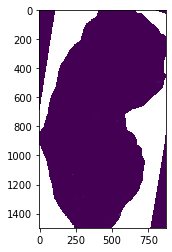

In [28]:
plt.imshow(warped_metals['Ca44'])

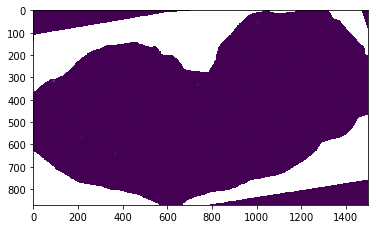

In [31]:
warped_metals = warp_metals(slide_x, slide_y, metals_x, metals_y)
plt.imshow(warped_metals['Ca44'])

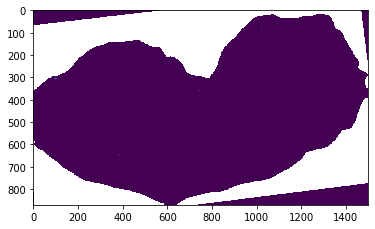

In [32]:
plt.imshow(metal_data['metals']['Ca44'])

In [33]:
metal_data['metals']['Ca44'].shape

(871, 1499)

In [34]:
im_small_crop.shape

(871, 1499, 3)

In [43]:
def rotate_image(img, angle):
    size_reverse = np.array(img.shape[1::-1]) # swap x with y
    M = cv2.getRotationMatrix2D(tuple(size_reverse / 2.), angle, 1.)
    MM = np.absolute(M[:,:2])
    size_new = MM @ size_reverse
    M[:,-1] += (size_new - size_reverse) / 2.
    return cv2.warpAffine(img, M, tuple(size_new.astype(int)), borderValue=-5000, 
#                           borderMode=cv2.BORDER_CONSTANT,
                         )

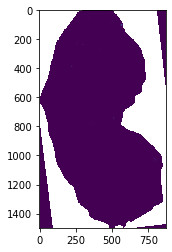

In [45]:
test = rotate_image(metal_data['metals']['Ca44'], 270)
test[test==-5000]=np.nan
plt.imshow(test)

In [113]:
pip install dash-uploader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.8/491.8 kB 2.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for dash-uploader: filename=dash_uploader-0.6.0-py3-none-any.whl size=69214 sha256=efb20cb7ea6782132998796c25a9d75bb5173511c8a7c5762a1f88b71aed298b
  Stored in directory: /Users/luyunrui/Library/Caches/pip/wheels/3b/4d/1c/941d4c28aa60af88391d34dd3f33d03b03372b33551f956b33
Successfully built dash-uploader

[notice] A new release of pip available: 22.1.2 -> 23.2.1
[notice] To update, run: /Users/luyunrui/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
